# Input Data

The input data for LUTO is a `pandas.DataFrame` where each column is a map and each row is ~1km*1km spatial coverage within continental Australia. Because crops and livestock require very different attributes, we have separated them into `data.AGEC_CROPS` and `data.AGEC_LVSTK`. Note that although uses pandas as the interface, the actual data is saved as `Hierarchical Data Format version 5 (HDF5)` files for better quering speed. Click [here](https://docs.hdfgroup.org/hdf5/v1_14/_intro_h_d_f5.html) to know more.

Observing input data for crops, we can see the index is `CELL_ID` and the column has 3 levels (indicating data type, water supply, and land use). However, livestock data does not have a water supply attribute. In LUTO, we multiply Livestorck's productivity by a factor of 2 to get its irrigated productivity. See [here](https://github.com/JinzhuWANG/luto-2.0/blob/dbe1fcfdf57075867a6f46de76dd6d0f872fa105/luto/economics/agricultural/quantity.py#L131) for the detailed implementation.

In [81]:
# HIDE CODE
df = data.AGEC_CROPS.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

print('Input data for the crops.')
df_styled

Input data for the crops.


In [82]:
# HIDE CODE
df = data.AGEC_CROPS.head(10)
df_styled = df.style.set_table_styles([
    {'selector': 'td', 'props': [('font-size', '10pt')]},
    {'selector': 'th', 'props': [('font-size', '10pt')]}
]).format(precision=2)

print('Input data for the livestock.')
df_styled

Input data for the livestock.


```{note}
Do you notice that the `CELL_ID` is not continuing, and there are a lot of `NaN` values in the dataframe? The discontinuity `CELL_ID` is due to data masking, and the None value comes from the exclusion masking. Essentialy, the data masking means we have removed some cells that will never be used in the analysis (e.g., cells cover sea, water, and intensive land-use like urban), and the None value indicates that the coresponding land-use can't exist in this cell. Let's plot the productivity data (`yield` record for crops, `P1/2/3` for livestock), have a visual on it, and then explain the data masking and exclusion masking.
```


The columns for water supply and land use are self-explanatory, but the column for data type may be confusing because of the abbreviated representation. Please refer to the below description for crop input to get the full description of crop variables. The description for livestock data shows the additional columns that LUTO needs for livestock animals.

In [86]:
# HIDE CODE
data_desc_crop = pd.read_csv('luto/tools/Manual_jupyter_books/asset/crop_data_description.csv').set_index(['Data type', 'Abbreviation'])
print('Description of the crop data.')
data_desc_crop

Description of the crop data.


Description
Data type Abbreviation                                
Cost      AC                          Area cost ($/ha)
          FDC           Fixed depreciation cost ($/ha)
          FLC                 Fixed labour cost ($/ha)
          FOC              Fixed operating cost ($/ha)
          QC                       Quantity cost ($/t)
Revenue   P1                   Price of output 1 ($/t)
Water     WR                  Water requirement (t/ha)
          WP                         Water price ($/t)
Yield     Yield               The yield of crop (t/ha)

In [87]:
# HIDE CODE
data_desc_lvstk = pd.read_csv('luto/tools/Manual_jupyter_books/asset/lvstk_data_description.csv').set_index(['Data type', 'Abbreviation'])
print('Description of the livestock data.')
data_desc_lvstk

Description of the livestock data.


Description
Data type            Abbreviation                                                   
Avaliable proportion F1            Fraction of herd to produce <Meat for BEEF and...
                     F2                   Fraction of herd to produce WOOL for SHEEP
                     F3            Fraction of herd as Live export for BEEF and S...
Yield                Q1                           Quantity of output 1 (tonnes/head)
                     Q2                           Quantity of output 2 (tonnes/head)
                     Q3             Quantity of output 3 (animal weight tonnes/head)
Price                P1                                      Price of output 1 ($/t)
                     P2                                      Price of output 2 ($/t)
                     P3                                      Price of output 3 ($/t)

## Economic, Environmental, and productivity data

In LUTO, the productivity is a map where each cell represents the unit production given a land-use. Note the productivities for crop, livestock and dairy are different.
- For crops, each productivity cell represents tonnes/ha
- For livestock, each productivity cell represents heads/ha
- For dairy, each productivity cell represents megalitres/ha

The productivity of crops lives in the `data.AGEC_CROPS` (livestock in the `data.AGEC_LVSTK`) variable as a pd.DataFrame. Both dataframes include cost, revenue, and water requirement data, in addition to productivity records. You can find their abbreviations and full descriptions below: 


In [10]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
agec_crops_xr = []
for col in data.AGEC_CROPS.columns:
    series = data.AGEC_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agec_crops_xr.append(series_xr)

# Combine the xarray objects
agec_crops_xr = xr.combine_by_coords(agec_crops_xr)

# Get the data for the given land-use
agec_crops_xr_lu = agec_crops_xr.sel(lu=lu_desc)

In [11]:
# REMOVE

# Helper function to plot the quantity matrices
def plot_dry_irr(dry_irr, irr_arr):

    # Create a figure and a set of subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

    # Plot the maps side by side
    dry_irr.plot(vmin=dry_irr.min(), vmax=dry_irr.max(), ax=axs[0])
    irr_arr.plot(vmin=irr_arr.min(), vmax=irr_arr.max(), ax=axs[1])

    # Optionally, adjust the layout
    plt.tight_layout()

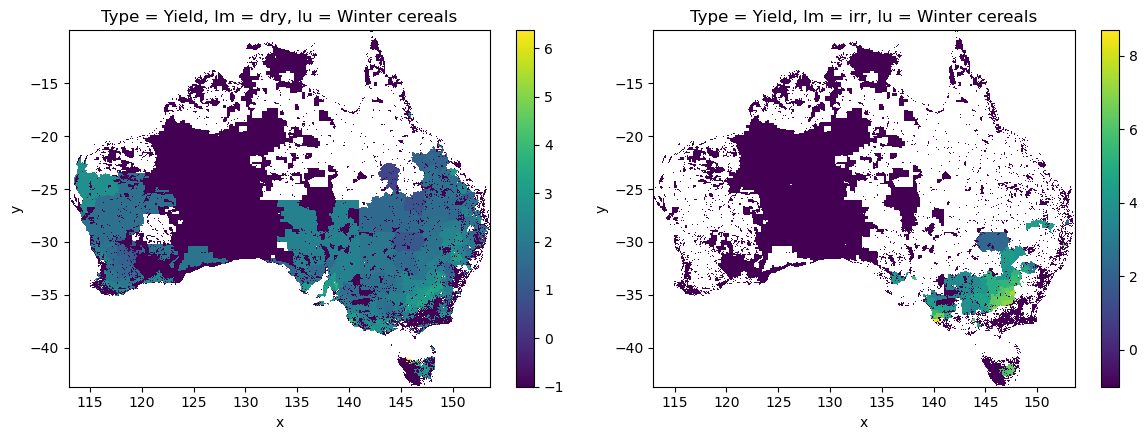

In [12]:
# HIDE CODE

# Get the yield for the given land-use
p_dry = agec_crops_xr_lu.sel(Type='Yield', lm='dry').drop_vars('spatial_ref')
p_irr = agec_crops_xr_lu.sel(Type='Yield', lm='irr').drop_vars('spatial_ref')

plot_dry_irr(p_dry, p_irr)

As discussed before, the productivity data need to be divided by water supply attribution (dry or irrigated). In addition, we can see there are 4 types of cells in the map: 
- white (or transparent) cells outside the continental Australia,  
- white (or transparent) cells inside the continental Australia, 
- dark purple cells (with -1 value) covers the non-agricultural land-use (water, desert, urban, etc.).
- colorful cells with values >= 0 and convey physical information (yield in this case).

Now let's discuss why we need data masking. A fact about these 2D maps is that even though we only care about the yield data, the computer still needs to store the white (transparent) cells! A glance at these maps could give us a quick estimate that more than half of the map's space was used to store meaningless information; that's not a good idea, and LUTO indeed has a way to deal with this waste. Below are the steps for LUTO to remove unnecessary data/cells. 

First, LUTO will drop the cells that cover the sea (outside continental Australia) using a national land-use mask (plotted below).

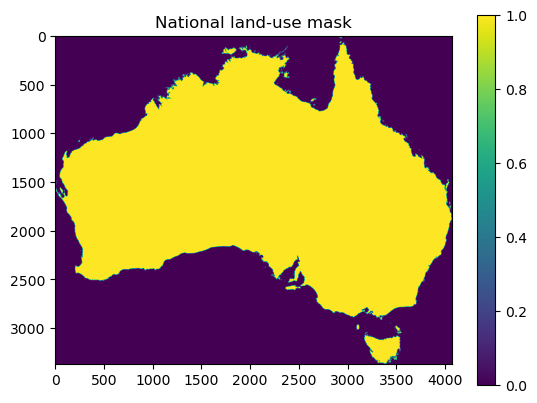

In [13]:
# HIDE CODE
plt.imshow(data.NLUM_MASK)
plt.colorbar()
plt.title('National land-use mask')
plt.show()

Next, LUTO uses a 'Land-use mask' to remove the non-agricultural land-use (e.g., water, desert, urban, etc.) 

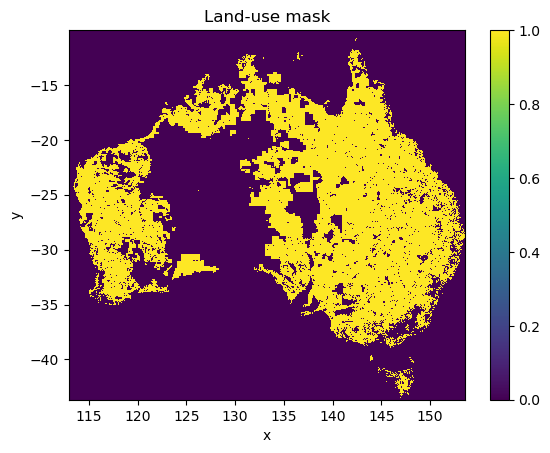

In [14]:
# HIDE CODE
lu_mask.plot()
plt.title('Land-use mask')
plt.show()

The 'National land-use mask' and 'Land-use mask' apply to all input data, but the exclusion mask is created separately for each land-use. In our case, the exclusion mask is a map indicating where is **suitable** and where is **not suitable** for caltivating winter cereal. LUTO uses a simple method to determine suitability for winter cereal: out of every [SA2](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/main-structure-and-greater-capital-city-statistical-areas/statistical-area-level-2) region, if this region had winter cereal in 2010, then the whole region would be suitable for winter cereal planting; otherwise, this region would be excluded from planting winter cereal in the future. In this manual, we will sum up all winter cereal cells in each SA2 region and make a plot to visulize this idea.

In [15]:
# REMOVE

sa2 = gpd.read_file('luto/tools/Manual_jupyter_books/asset/sa2_2011_aus/SA2_2011_AUST_continental_simplified.shp')

# Get the sum of pixels for each SA2 region
lu_dry_bool = np.where(lu_arr_dry.values == 1, 1, 0)
lu_irr_bool = np.where(lu_arr_irr.values == 1, 1, 0)

lu_dry_sa2_sum = zonal_stats(sa2, lu_dry_bool, affine=lu_arr_dry.rio.transform(), nodata=0, stats='sum')
lu_irr_sa2_sum = zonal_stats(sa2, lu_irr_bool, affine=lu_arr_irr.rio.transform(), nodata=0, stats='sum')

sa2['dry_count'] = [x['sum'] for x in lu_dry_sa2_sum]
sa2['irr_count'] = [x['sum'] for x in lu_irr_sa2_sum]


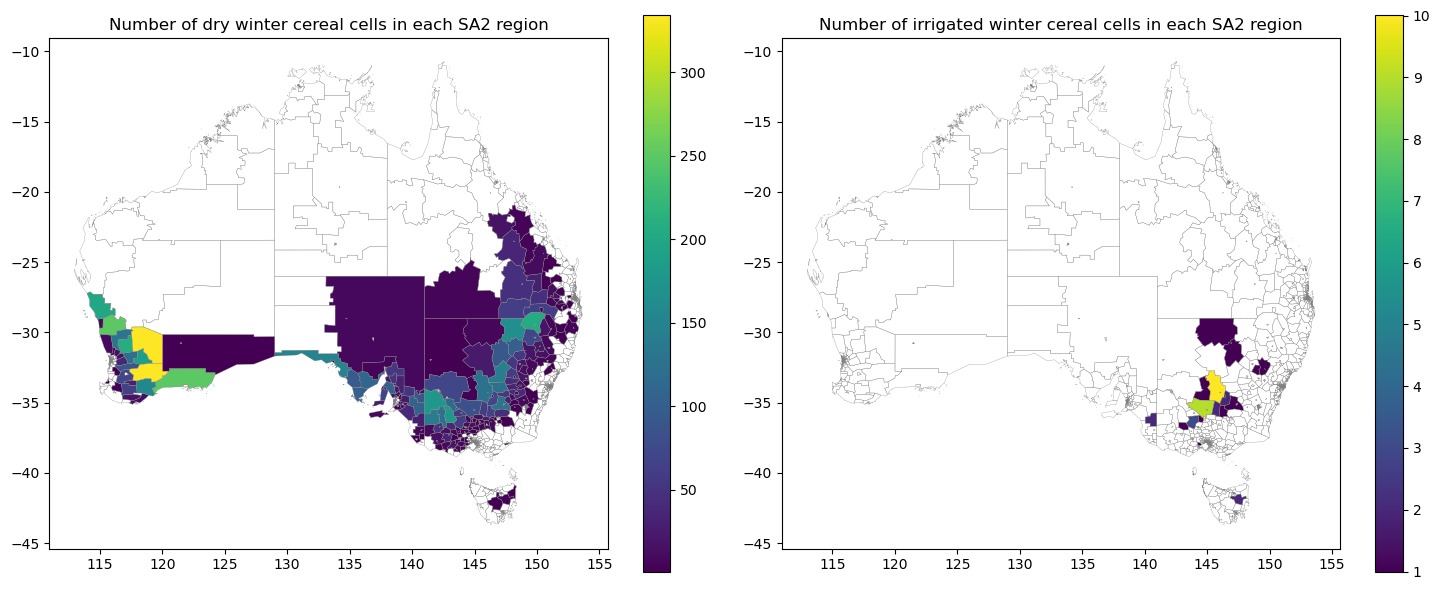

In [16]:
# HIDE CODE
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot for dry_count
sa2.plot(ax=ax[0], column='dry_count', legend=True)
sa2.plot(ax=ax[0], color='none', edgecolor='grey', linewidth=0.2)
ax[0].set_title('Number of dry winter cereal cells in each SA2 region')

# Plot for irr_count
sa2.plot(ax=ax[1], column='irr_count', legend=True)
sa2.plot(ax=ax[1], color='none', edgecolor='grey', linewidth=0.2)
ax[1].set_title('Number of irrigated winter cereal cells in each SA2 region')

plt.tight_layout()
plt.show()

Now the last piece for productivity is completed! If you look at the above exclusion masks and compare them with the yield map of winter cereal, you will find that yield data only exist in the'suitable SA2 regions', which is a way to avoid its plantation outside the suitable zones.

```{warning}
We noticed that some SA2 regions have only a few winter cereal plantations but cover a large area that is not suitable for winter cereal's cultivation. This is a known issue in LUTO and will be fixed in the near future.
```

OK, we have yield for winter cereal, but something is still missing. The yield map only represents the productivity for 2010, and we want to get the yield for the whole 2010–2100 period. Because crop productivity is primarily determined by climate change, we will use it as a proxy to extend yield from 2010 to 2100.

## Climate change impacts

We used the `attainable yield` data from [GAEZ](https://gaez.fao.org/) to calculate climate change's impact on crop yield. Attainable yield is the maximum yield under optimal management practices and without the limitations of water, nutrients, pests, or diseases, but within the constraints of local climate and soil conditions. It is safe to say that attainable yield is directly related to climate change, and that's why we (and many other studies) use it to quantify climate change's influences on crops. 

```{note}
GAEZ attainable yield includes several climate models (CRUTS32, GFDL-ESM2M, HadGEM2-ES, IPSL-CM5A-LR, MIROC-ESM-CHEM, NorESM1-M). In LUTO, we used the mean value across all models as the input attainable yield. Climate change is also predicted to have different paths. LUTO has a `settings.RCP` (one of rcp2p6, rcp4p5, rcp6p0, and rcp8p5) to specify the climate change scenarios. Note that this scenario setting is shared among many input data (demand, biodiversity, water use, etc.). In addition to RCP, the assumption on CO2 fertilization effect also has significant impacts on attainable yield, and LUTO has a `settings.CO2_FERT` ('on' or 'off') for us to choose if we want to include this effect. 
```

In [17]:
# REMOVE

# Convert the `AGEC_CROPS` data to 2D xarray
cci_crops_xr = []
for col in data.CLIMATE_CHANGE_IMPACT.columns:
    series = data.CLIMATE_CHANGE_IMPACT[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'lm': [col[0]], 
        'lu': [col[1]], 
        'year': [col[2]]
    })
    cci_crops_xr.append(series_xr)

# Combine the xarray objects
cci_crops_xr = xr.combine_by_coords(cci_crops_xr)


# Append ones as the climate change impact in year 2010
cci_ones_dry = cci_crops_xr.sel(lm=['dry'], year=[2020])
cci_ones_dry.data = np.ones_like(cci_ones_dry.data)
cci_ones_dry.coords['year'] = [2010]
cci_ones_irr = cci_crops_xr.sel(lm=['irr'], year=[2020])
cci_ones_irr.data = np.ones_like(cci_ones_irr.data)
cci_ones_irr.coords['year'] = [2010]
cci_crops_xr = xr.combine_by_coords([cci_crops_xr, cci_ones_dry, cci_ones_irr])


# Get the data for the given land-use
cci_crops_xr_lu = cci_crops_xr.sel(lu=lu_desc)
# Linearly interpolate the data to 2010-2100
cci_crops_xr_lu = cci_crops_xr_lu.interp(year=range(2010, 2101), method='linear', kwargs={"fill_value": "extrapolate"})

In this manual, we chose the `settings.rcp == 'rcp4p5'` scenario and plotted the climate impact below. From it, we can see that climate change impact is introduced as a multiplier to crop yield. The climate change in 2050 is mostly positive for winter cereal. Also, note that this impact multiplier only exists in the'suitable zones', which means that we have intentionally excluded winter cereal from cultivating in unsuitable areas.

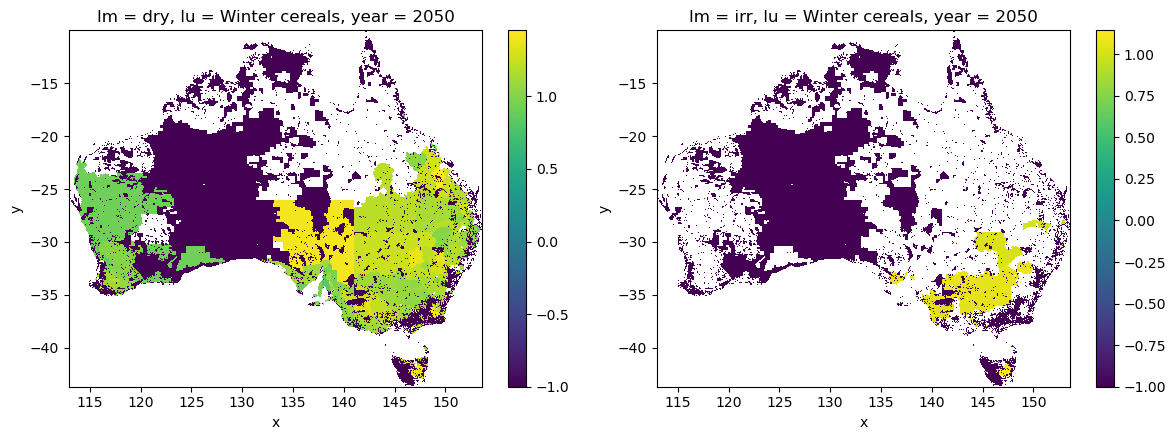

In [18]:
# HIDE CODE

# Get the data for the given year
cci_dry = cci_crops_xr_lu.sel(lm='dry', year=year_target).drop_vars('spatial_ref')
cci_irr = cci_crops_xr_lu.sel(lm='irr', year=year_target).drop_vars('spatial_ref')

plot_dry_irr(cci_dry, cci_irr)

In [19]:
# REMOVE


# Functiont to read the climate change impact data and convert it to xarray
def read_cc_impact(rcp, co2, lu=lu_desc):
    df = pd.read_hdf(os.path.join('input', "climate_change_impacts_" + rcp + "_CO2_FERT_" + co2 + ".h5")).iloc[data.MASK]
    df = df.loc[:, (slice(None), lu_desc, slice(None))]
    df = df.unstack().reset_index().rename(columns={'level_0': 'water_supply', 'level_1': 'Land-use', 'level_2': 'Year', 0: 'Value'})
    
    # Convert the data to xarray
    df_xr = []
    for col, df_ in df.groupby(['water_supply', 'Land-use', 'Year']):
        arr_xr = arr_to_xr(data, df_['Value']).expand_dims({
            'lm': [col[0]],
            'lu': [col[1]],
            'year': [col[2]]
        })
        df_xr.append(arr_xr)
    df_xr = xr.combine_by_coords(df_xr)

    # Append ones as the climate change impact in year 2010
    ones_xr = df_xr.sel(year=[2020]) / df_xr.sel(year=[2020])
    ones_xr.coords['year'] = [2010]
    df_xr = xr.combine_by_coords([df_xr, ones_xr])

    # Interpolate the data to 2010-2100
    df_xr = df_xr.interp(year=list(df_xr['year'].values) + [2100], method='linear', kwargs={"fill_value": "extrapolate"})
    
    # Add rcp and co2_fert as coordinates
    df_xr = df_xr.expand_dims({'rcp': [rcp], 'co2_fert': [co2]})
        
    return df_xr

In [20]:
# REMOVE

# Read the climate change impact data
rcps = ['rcp2p6', 'rcp4p5', 'rcp6p0', 'rcp8p5']
co2_fert = ['on', 'off']

cc_impacts = []
for rcp,co2 in tqdm(product(rcps, co2_fert)):
    arr = read_cc_impact(rcp, co2)
    cc_impacts.append(arr)
    
cc_impacts = xr.combine_by_coords(cc_impacts)

0it [00:00, ?it/s]

If you are curious about climate change's impact under different `RCP` and `CO2 Fertilization` effects, we have prepared a plot to illustrate the mean value of all climate change multipliers below. We can see that winter cereal's yields under dry and irrigated water supplies are significantly different. Also note the opposite trend of yield trajectory prediction under different CO2 fertilization effects. It is clear that we have to be very careful when choosing the right RCP and CO2_fert parameters in LUTO because different assumptions will lead to very different agricultural productivity in the future!

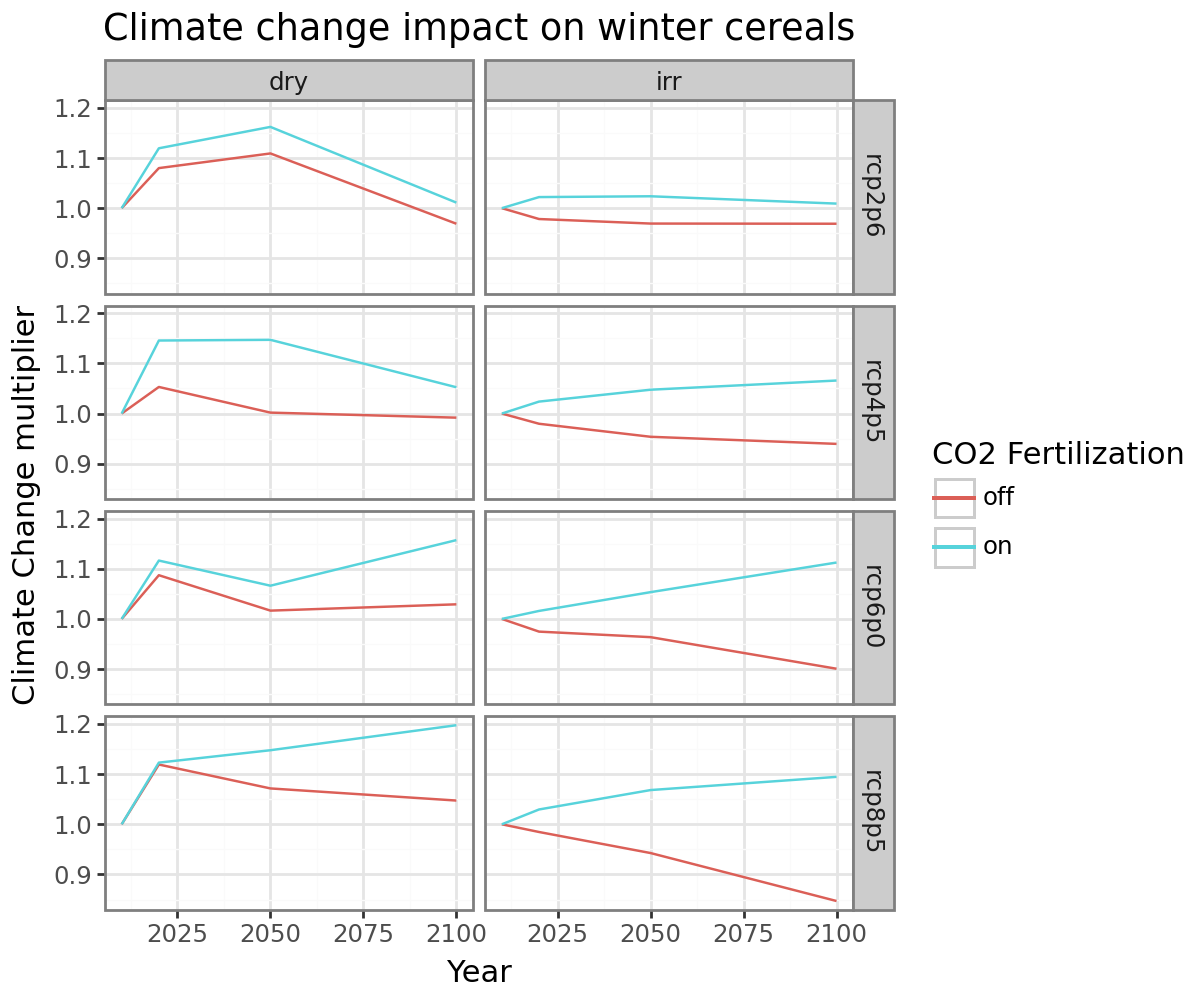

In [21]:
# HIDE CODE

cc_impacts_lu = cc_impacts * lu_mask.where(lu_mask == 1)
cc_impacts_lu_stats = cc_impacts_lu.mean(dim=['x', 'y']).to_dataframe(name='cc_multiplier').reset_index()

(p9.ggplot(cc_impacts_lu_stats)
     + p9.geom_line(p9.aes(x='year', y='cc_multiplier', color='co2_fert'))
     + p9.facet_grid('rcp ~ lm')
     + p9.theme_bw()
     + p9.labs(title='Climate change impact on winter cereals', x='Year', y='Climate Change multiplier', color='CO2 Fertilization')
)